In [80]:
from tifffile import imread, imwrite

from PIL import Image
import numpy as np

np.random.seed(1001)


from multiprocessing import Queue
from classifiers import DeepFeaturesModel, WekaFeaturesModel, get_featuriser_classifier
import hr_dv2.transform as tr
from hr_dv2.utils import *
from hr_dv2.high_res import torch_pca

from skimage.util import random_noise
from skimage.color import label2rgb
import matplotlib.pyplot as plt

In [53]:
cmap = [
            "#fafafa",
            "#1f77b4",
            "#ff7f0e",
            "#2ca02c",
            "#d62728",
        ]
color_list = [[255, 255, 255], [31, 119, 180], [255, 127, 14], [44, 160, 44], [255, 0, 0]]
COLORS = np.array(color_list) / 255.0

In [2]:
def tiff_to_labels(tiff: np.ndarray, rev: bool=False) -> np.ndarray:
    if tiff.shape[0] == 1:
        tiff = tiff[0]
    out = tiff
    vals = np.unique(tiff)[::-1] if rev else np.unique(tiff)
    for i, val in enumerate(vals):
        out = np.where(tiff == val, i, out)
    return out

def remap_label_arr(arr: np.ndarray) -> np.ndarray:
    if arr.shape[0] == 1:
        arr = arr[0]
    out = np.zeros_like(arr)
    for i, val in enumerate(sorted(np.unique(arr))):
        out = np.where(arr == val, i, out)
    return out

def centre_crop(img_or_arr: np.ndarray |  Image.Image, cw: int, ch: int) -> np.ndarray | Image.Image:
    if type(img_or_arr) == np.ndarray:
        arr: np.ndarray = img_or_arr #type:ignore
        ih, iw = arr.shape
        oy, ox = (ih - ch) // 2, (iw - cw) // 2
        cropped = arr[oy:oy+ch, ox:ox+cw]
        return cropped
    else:
        img: Image.Image = img_or_arr #type: ignore
        ih, iw = img.height, img.width
        oy, ox = (ih - ch) // 2, (iw - cw) // 2
        bbox = (ox, oy, ox + cw, oy + ch)
        return img.crop(bbox)

def swap_label_vals(arr: np.ndarray, val_0: int, val_1: int, swap_val: int = 100) -> np.ndarray:
    tmp = np.where(arr == val_0, swap_val, arr)
    tmp = np.where(arr == val_1, val_0, tmp)
    tmp = np.where(arr == swap_val, val_1, tmp)
    return tmp

In [3]:
dinov2_noflip_model = get_featuriser_classifier("DINOv2-S-14", Queue(2), Queue(2), trs='shift')
dinov2_flip_model = get_featuriser_classifier("DINOv2-S-14", Queue(2), Queue(2), trs='both')
rf_model = get_featuriser_classifier("RF", Queue(2), Queue(2))

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")
Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main


In [4]:
dinov2_noflip_model.do_crf = False
dinov2_flip_model.do_crf = False
rf_model.do_crf = False

In [30]:
_img = imread('pos_bias_data/default_image_crop_for_dino.tif')
_h, _w = _img.shape
img = Image.fromarray(_img).resize((int(_w / 2), int( _h / 2))).convert('RGB')
img_arr = (np.array(img.convert('L')) * 255).astype(np.uint8)
labels_data = imread('pos_bias_data/sofc_biased_labels_crop_for_dino.tif')

labels_arr = tiff_to_labels(labels_data)
labels_arr = labels_arr[::2, ::2]

In [6]:
classical_features = rf_model.img_to_features(img)
rf_model.train([classical_features], [labels_arr])

In [7]:
classical_seg = rf_model.segment([classical_features], [img], [0])

In [8]:
deep_feats_noflip = dinov2_noflip_model.img_to_features(img.convert('RGB'))
deep_feats_noflip = np.nan_to_num(deep_feats_noflip, nan=-1000)
dinov2_noflip_model.train([deep_feats_noflip], [labels_arr],)

In [82]:
print(deep_feats_noflip.shape)

(448, 504, 384)


In [ ]:
h, w, c = deep_feats_noflip.shape
deep_feats_noflip_flat = deep_feats_noflip.reshape((h * w, c))
pcaed = do_single_pca(deep_feats_noflip_flat, 3, n_samples=80000)
rescaled = rescale_pca(pcaed)
deep_feats_noflip_pca = rescaled.reshape((h, w, 3))

(225792, 3)


In [9]:
deep_feats_flip = dinov2_flip_model.img_to_features(img.convert('RGB'))
deep_feats_flip = np.nan_to_num(deep_feats_flip, nan=-1000)
dinov2_flip_model.train([deep_feats_flip], [labels_arr],)

In [98]:
h, w, c = deep_feats_flip.shape
deep_feats_flip_flat = deep_feats_flip.reshape((h * w, c))
pcaed = do_single_pca(deep_feats_flip_flat, 3, n_samples=80000)
rescaled = rescale_pca(pcaed)
deep_feats_flip_pca = rescaled.reshape((h, w, 3))

In [10]:
deep_seg_noflip = dinov2_noflip_model.segment([deep_feats_noflip], [img], [0])
deep_seg_flip = dinov2_flip_model.segment([deep_feats_flip], [img], [0])

In [110]:
overlaid = label2rgb(labels_arr, (255 -img_arr), kind='overlay', colors=COLORS[1:], alpha=0.4)

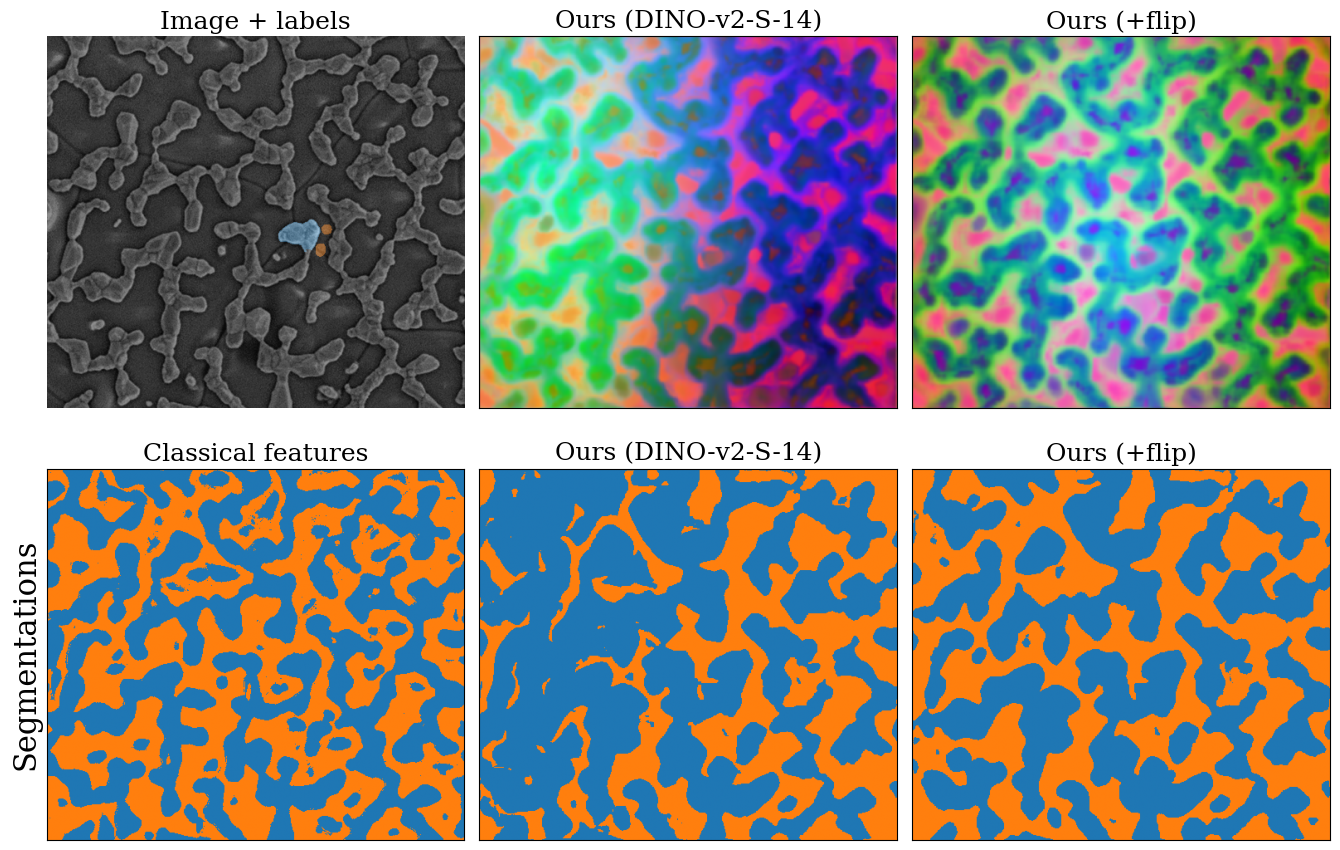

In [111]:
fig, axs = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(4.5 * 3, 9)
plt.rcParams["font.family"] = "serif"

axs[0, 0].imshow(overlaid)
axs[0, 0].set_axis_off()
axs[0, 0].set_title("Image + labels", fontsize=18)


titles = ["Ours (DINO-v2-S-14)", "Ours (+flip)"]
feat_pcas = [deep_feats_noflip_pca, deep_feats_flip_pca]
for i in range(2):
    ax = axs[0, 1 + i]
    ax.set_title(titles[i], fontsize=18)
    ax.imshow(feat_pcas[i])

    ax.set_xticks([])
    ax.set_yticks([])



titles = ["Classical features", "Ours (DINO-v2-S-14)", "Ours (+flip)"]
segs = [classical_seg, deep_seg_noflip, deep_seg_flip]
axs[1, 0].set_ylabel("Segmentations", fontsize=22)
for i in range(3):
    ax = axs[1, i]
    img = label2rgb(segs[i][0], colors=COLORS[1:])
    ax.set_title(titles[i], fontsize=18)
    ax.imshow(img)

    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

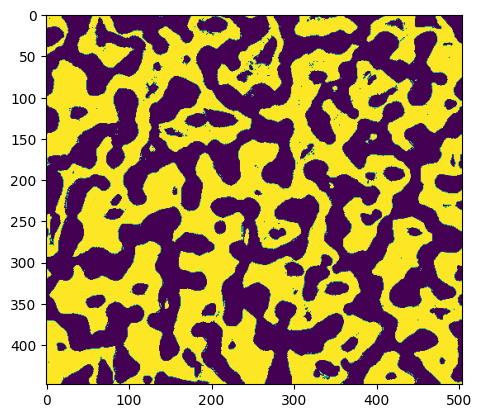

In [25]:
plt.imshow(classical_seg[0])

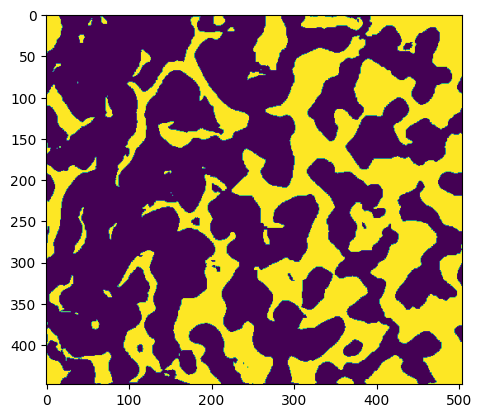

In [12]:
plt.imshow(deep_seg_noflip[0])

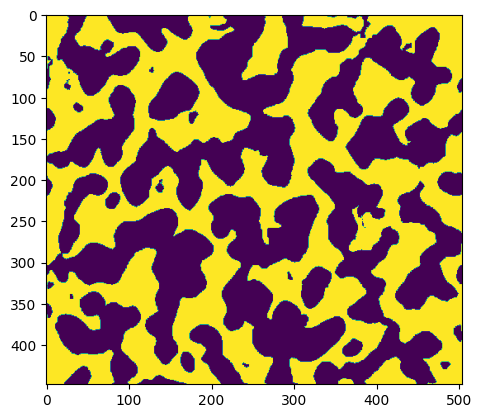

In [13]:
plt.imshow(deep_seg_flip [0])